
# Running a Phylogenetic OU Regression with R and Stan



In this notebook, I will illustrate how one can set up a logistic regression with a phylogenetic random effect following an Ornstein-Uhlenbeck process using R and Stan. 

This kind of analysis has conceptual advantages compared with alternatives - such as phylogenetic random effects following a Brownian motion, or correlated evolution using discrete characters and the CTMC model. However, while there are off-the-shelf solutions for the latter two, the OU regression is, to my knowledge, not yet implemented in a dedicated function or package. Such a model can be set up quite easily in Stan, however. This notebook serves to illustrate how this can be done.


## Preparing the environment

The git repository https://github.com/gerhardJaeger/OU_logistic_example holds the source code for this notebook. It contains a file `OU_logistic_example.yml`. You can use it to set up a conda environment containing all the required packages. (Of course you can also install the packages with `install.packages` if you don't use conda.) At the command prompt, in the home directory of the repository, do

```{bash}
conda env create -f OU_logistic_example.yml
conda activate OU_logistic_example
```

## Loading the required packages


In [1]:
suppressPackageStartupMessages({
  suppressWarnings({
    library(tidyverse)
    library(rstan)
    library(parallel)
    rstan_options(auto_write = TRUE)
    options(mc.cores = parallel::detectCores())  # Enable parallel Stan sampling
    library(ape)
    library(R.utils)
    library(bridgesampling)
    library(loo)
    library(bayesplot)
    library(codetools)
    library(ggtree)
    library(posterior)
    library(tidybayes)
    library(ggthemes)
    library(paletteer)
    library(ggnewscale)
    library(cowplot)
    options(repr.plot.width = 12, repr.plot.height = 8)  # For base R plots in Jupyter
    theme_set(theme_minimal(base_size = 24))  # Increase base font size
  })
})

## Data

Now let's get some data. I will use the EDGE tree (Bouckaert 2022).

In [2]:
# Create data directory if it doesn't exist
if (!dir.exists("../data")) dir.create("../data", recursive = TRUE)

# Download the file if it doesn't exist
tree_gz <- "../data/global-language-tree-MCC-labelled.tree.gz"
tree_file <- "../data/global-language-tree-MCC-labelled.tree"
if (!file.exists(tree_file)) {
    download.file(
        url = "https://github.com/rbouckaert/global-language-tree-pipeline/releases/download/v1.0.0/global-language-tree-MCC-labelled.tree.gz",
        destfile = tree_gz,
        mode = "wb"
    )
    R.utils::gunzip(tree_gz, destname = tree_file, overwrite = TRUE)
    # Remove the gzipped file after extraction
    if (file.exists(tree_gz)) file.remove(tree_gz)
}

edge_tree <- read.nexus(tree_file)

edge_tree$tip.label <- sapply(strsplit(edge_tree$tip.label, "_"), `[`, 1)

It is advisable to rescale the tree so that the mean branch length is 1.

In [3]:
edge_tree$edge.length <- edge_tree$edge.length / (mean(edge_tree$edge.length))

## Grambank data

I will look at the somewhat boring feature pair:
- GB193: What is the order of adnominal property word and noun?
- GB133: Is a pragmatically unmarked constituent order verb-final for transitive clauses?



First we get the grambank data.

In [4]:
grambank_file = "../data/grambank_vals.csv"
if (!file.exists(grambank_file)) {
    values_url <- "https://raw.githubusercontent.com/grambank/grambank/refs/heads/master/cldf/values.csv"
    vals <- read_csv(values_url, na = "")
    write(vals, grambank_file)
} else {
    vals <- read_csv(grambank_file)
}

Rows: 441663 Columns: 9
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (9): ID, Language_ID, Parameter_ID, Value, Code_ID, Comment, Source, Sou...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Now we filter out the datapoints for the two parameters of interest and the languages in the tree. I only consider two values per parameter, and only languages having a relevant value for both parameters.

In [5]:
d <- vals %>%
    filter(Language_ID %in% edge_tree$tip.label) %>%
    filter(Parameter_ID %in% c("GB193", "GB133")) %>%
    select(Language_ID, Parameter_ID, Value) %>%
    filter(Value %in% c(0, 1, 2)) %>%
    mutate(Value = as.numeric(Value)) %>%
    pivot_wider(names_from = Parameter_ID, values_from = Value) %>%
    filter(GB193 > 0) %>%
    drop_na()

Now we prune the tree to only include the languages in the data.

In [6]:
pruned_tree <- drop.tip(edge_tree, setdiff(edge_tree$tip.label, d$Language_ID))

# Check that d$Language_ID and pruned_tree$tip.label are the same set
if (!setequal(d$Language_ID, pruned_tree$tip.label)) {
    warning("Mismatch between d$Language_ID and pruned_tree$tip.label")
    print(setdiff(d$Language_ID, pruned_tree$tip.label))
    print(setdiff(pruned_tree$tip.label, d$Language_ID))
} else {
    message("d$Language_ID and pruned_tree$tip.label match.")
}

d$Language_ID and pruned_tree$tip.label match.



Now the rows in `d` are rearranged to match the order of the tips in the pruned tree.

In [7]:
d <- d[match(pruned_tree$tip.label, d$Language_ID), ]

Finally we convert the features to numeric values, and convert to 0/1

In [8]:
d <- d %>%
    mutate(x = GB193 - 1,
           y = GB133 
    )

Let's have a look at the tree and the data.

For now, I keep the data set small and restrict myself to 100 taxa.

In [9]:
set.seed(123)  # You can replace 123 with any integer
d <- d[sample(nrow(d), 100), ]
pruned_tree <- drop.tip(pruned_tree, setdiff(pruned_tree$tip.label, d$Language_ID))
d <- d[match(pruned_tree$tip.label, d$Language_ID), ]

Language_ID,GB133,GB193,x,y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
adan1251,1,2,1,1
ajas1235,0,1,0,0
alab1254,1,1,0,1
alya1239,0,2,1,0
arch1244,1,1,0,1
aree1239,1,2,1,1
arig1246,0,1,0,0
awar1249,1,2,1,1
band1344,0,1,0,0


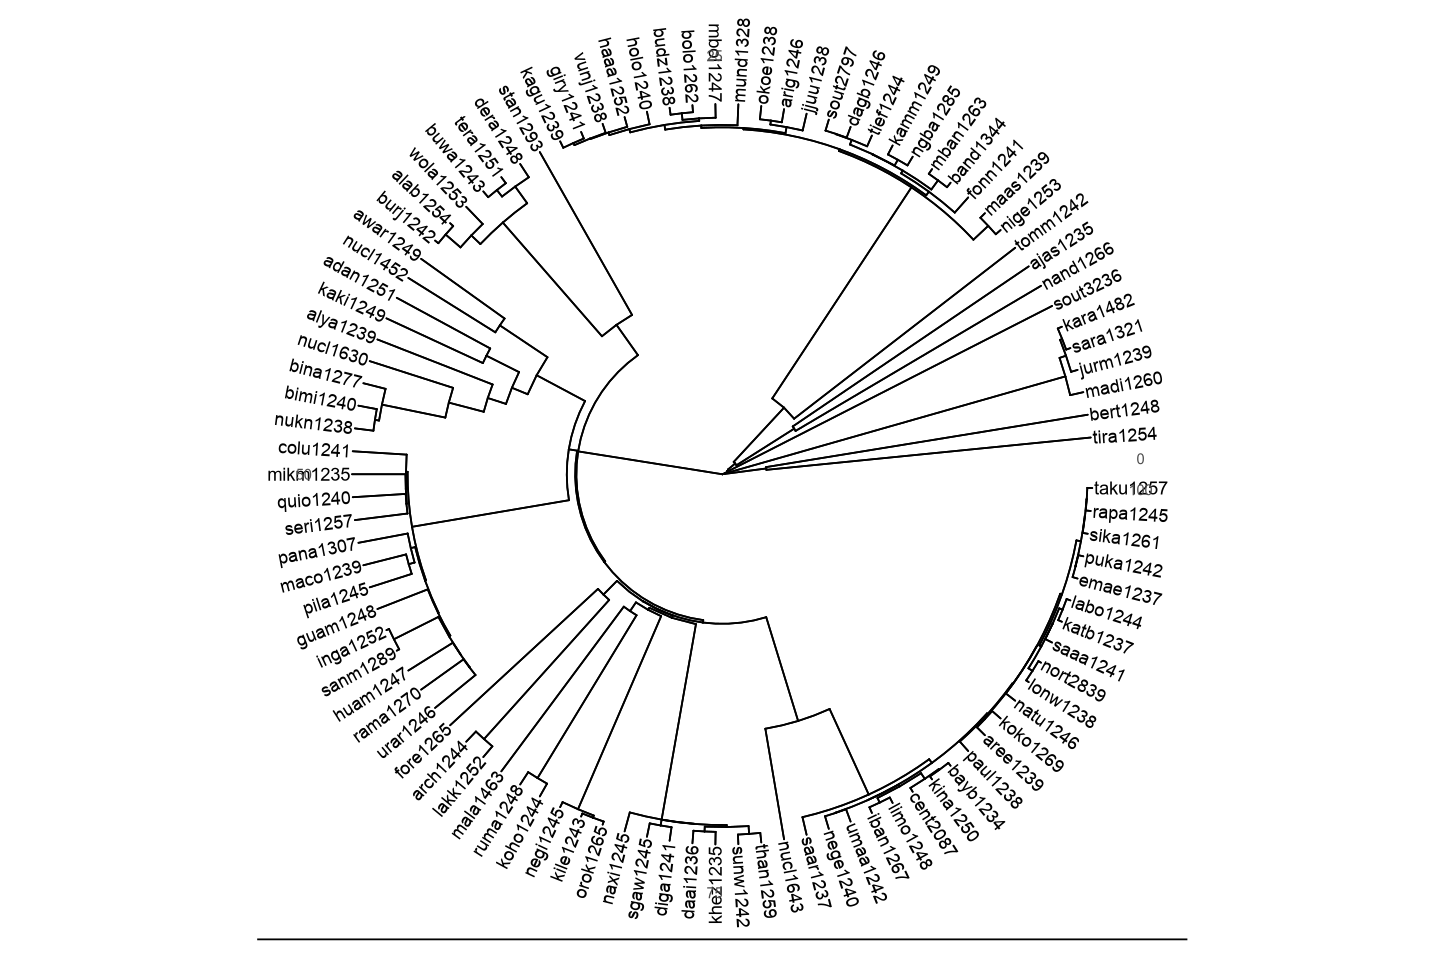

In [10]:
ggtree(pruned_tree, layout="circular") +
    geom_tree() +
    geom_tiplab() +            # Adds tip labels
    theme_tree2()              # Adds scale axis (x-axis for branch lengths)


d %>% head(10)

## Stan model

The tree is represented as a phylo object in `ape`, which is suitable for Stan.

Just to be on the safe side, we make sure that the branches are in postorder.

In [11]:
pruned_tree <- reorder(pruned_tree, "postorder")

Now we code the tree and the data as a data list.

In [12]:
stan_data = list(
    N = nrow(d),  # Number of languages
    Nnodes = length(unique(as.vector(pruned_tree$edge))),
    root_node = length(pruned_tree$tip.label) + 1,
    x = d$x,  # Predictor variable (numeral-noun order)
    y = d$y,  # Response variable (adnominal demonstrative-noun order)
    Nedges = nrow(pruned_tree$edge), # number of edges
    edges = pruned_tree$edge,  # Edges of the tree,
    edge_lengths = pruned_tree$edge.length  # Lengths of the edges
)

### Vanilla logistic regression

We start with a simple logistic regression without any phylogenetic effects, just to see how it works.

The model formula is:

$$
\begin{align}
\alpha &\sim \mathcal N(0, 10)\\
\beta &\sim \mathcal N(0, 10)\\
y &\sim \text{Bernoulli}(\text{logit}^{-1}(\alpha + \beta x))
\end{align}
$$

Let's run this in Stan.

In [13]:
stan_code_vanilla <- "
data {
    int<lower=1> N;                      // Number of observations
    vector<lower=0, upper=1>[N] x;       // Predictor variable
    array[N] int<lower=0,upper=1> y;     // Response variable (binary)
}
parameters {
    real alpha;      // Intercept
    real beta;       // Slope
}
model {
    // Priors
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);

    // Likelihood
    y ~ bernoulli_logit(alpha + beta * x);
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N) {
        log_lik[n] = bernoulli_logit_lpmf(y[n] | alpha + beta * x[n]);
    }
}
"
stan_model_vanilla <- stan_model(model_code = stan_code_vanilla)

In [14]:

fit_vanilla <- sampling(stan_model_vanilla, data = stan_data, iter = 2000, chains = 4)

In [15]:
print(fit_vanilla, pars = c("alpha", "beta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%  50%   75% 97.5% n_eff Rhat
alpha  0.29    0.01 0.39 -0.48  0.03  0.3  0.55  1.03   918    1
beta  -1.09    0.02 0.48 -2.02 -1.41 -1.1 -0.76 -0.15   884    1

Samples were drawn using NUTS(diag_e) at Sun Jun 15 09:22:44 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


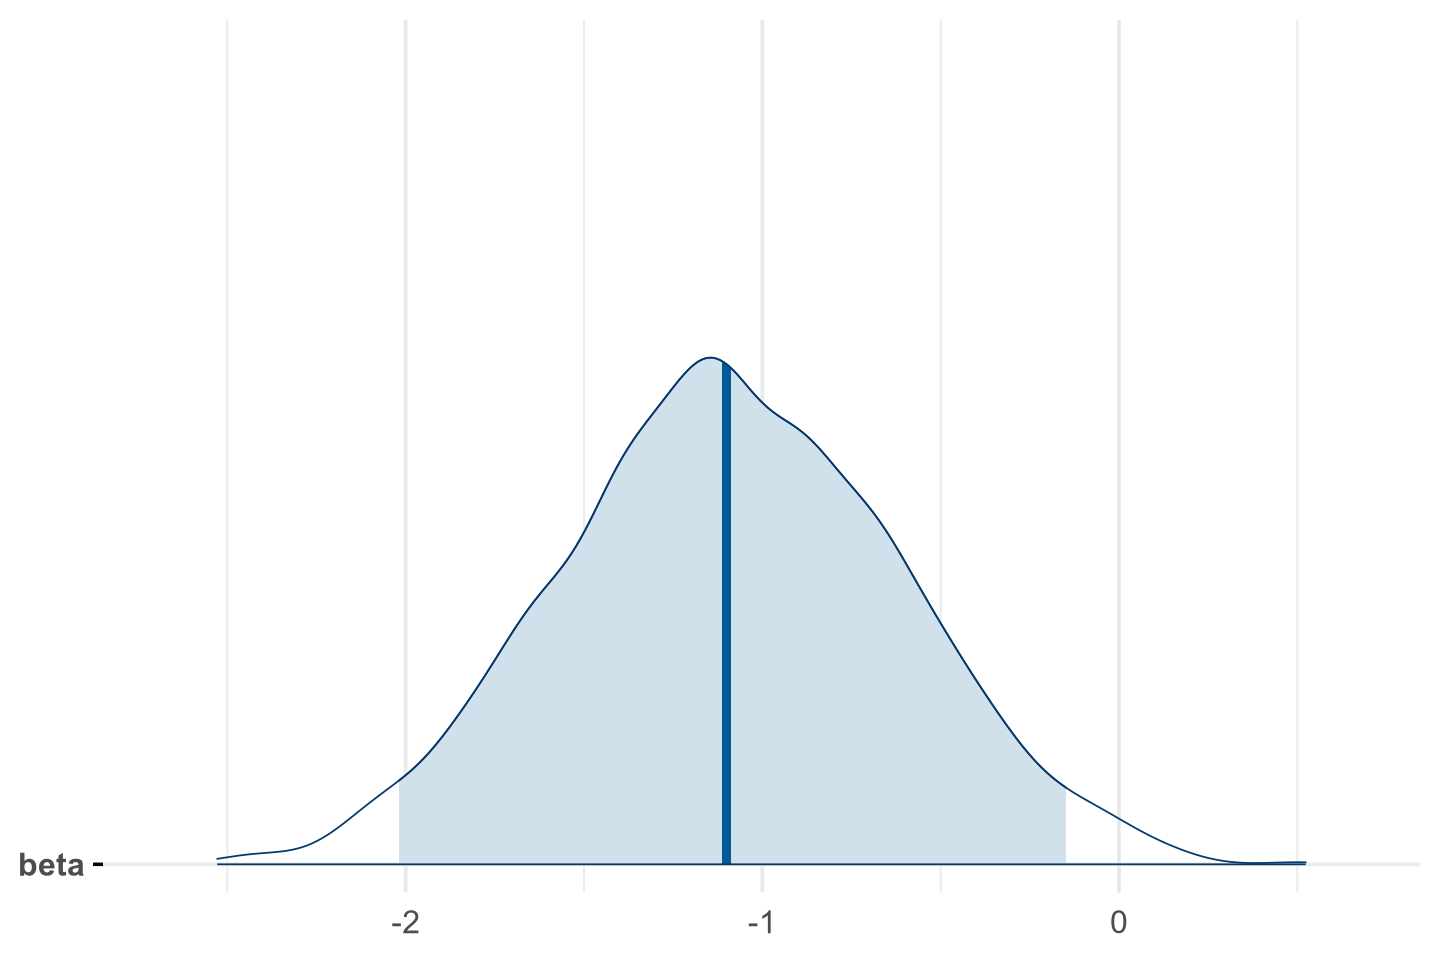

In [16]:
mcmc_areas(
    as.matrix(fit_vanilla),
    pars="beta",
    prob = 0.95
)

The posterior distribution of the slope $\beta$ does not include zero, indicating that there is a significant relationship between the predictor variable `x` and the response variable `y`. The direction is negative, meaning that N-ANM order disfavors OV order.


For model comparison, we can use the `bridgesampling` package to compute the log marginal likelihood.

In [17]:
capture.output({
  log_marginal_likelihood_vanilla_regression <- bridge_sampler(fit_vanilla)
}, file = "/dev/null")

print(log_marginal_likelihood_vanilla_regression)

Bridge sampling estimate of the log marginal likelihood: -64.61308
Estimate obtained in 5 iteration(s) via method "normal".


### Vanilla logistic correlation study

A regression model assumes an asymmetry between the predictor variable (which is not modeled) and the response variabel (which is modeled). This is not really justified in observational studies where we have not control over the predictor variable. A more appropriate model is one where both variables are generated by some stochastic process. 

This can be modeled as follows:

$$	
\begin{align}
z &\sim \mathcal N(\mu, R)\\
R &\sim \text{LKJ}(2)\\
\mu &= \mathcal N(\mathbf 0, 100\mathbf I)\\
x &\sim \text{Bernoulli}(\text{logit}^{-1}(z_1))\\
y &\sim \text{Bernoulli}(\text{logit}^{-1}(z_2))
\end{align}
$$

Here $z$ is a bivariate normal variable with mean $\mu$ and covariance $R$. The two components of $z$ have standard deviations 1, and the correlation between them is given by $\rho = R_{12} = R_{21}$. The correlation matrix is generated from a uniform distribution distribution, which is a flexible way to model correlations. The two variables $x$ and $y$ are then generated from the first and second components of $z$, respectively, using the logistic function. 

The interesting question is then whether the correlation between $x$ and $y$, i.e., $\rho = r_{21}$, is significantly different from zero. If it is, this indicates that there is a significant correlation between the two variables, which is what we are interested in.

In [18]:
stan_code_vanilla_corr <- "
data {
  int<lower=0> N;
  array[N] int<lower=0, upper=1> x;       // first binary variable
  array[N] int<lower=0, upper=1> y;       // second binary variable
}

parameters {
  vector[2] mu;                          // Mean of latent variables
  cholesky_factor_corr[2] L_R;           // Cholesky factor of correlation matrix
  matrix[2, N] z_raw;                    // Standard normal latent variables
}

transformed parameters {
  real rho = L_R[2, 1];                  // Extract the correlation coefficient from the Cholesky factor
  matrix[2, N] z;                        // Latent variables with correlation
  z = rep_matrix(mu, N) + L_R * z_raw;   // Transform raw latent variables to correlated latent variables
}

model {
  // Priors
  mu ~ normal(0, 10);                       // Prior for the mean of latent variables
  L_R ~ lkj_corr_cholesky(2);              // Prior for the Cholesky factor of the correlation matrix
  to_vector(z_raw) ~ normal(0, 1);         // standard normal prior for latent

  // Likelihood
  for (n in 1:N) {
    x[n] ~ bernoulli_logit(z[1, n]);
    y[n] ~ bernoulli_logit(z[2, n]);
  }
}

generated quantities {
  vector[N] log_lik_x;
  vector[N] log_lik_y;

  for (n in 1:N) {
    log_lik_x[n] = bernoulli_logit_lpmf(x[n] | z[1, n]);
    log_lik_y[n] = bernoulli_logit_lpmf(y[n] | z[2, n]);
  }
}
"
stan_model_vanilla_corr <- stan_model(model_code = stan_code_vanilla_corr)

In [19]:
fit_vanilla_corr <- sampling(
    stan_model_vanilla_corr,
    data = stan_data,
    iter = 2000,
    chains = 4
)

In [20]:
print(fit_vanilla_corr, pars = c("mu", "rho"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu[1]  1.03    0.00 0.26  0.53  0.85  1.03  1.20  1.55  8660    1
mu[2] -0.55    0.00 0.25 -1.05 -0.71 -0.53 -0.38 -0.06  7937    1
rho   -0.47    0.01 0.30 -0.92 -0.70 -0.51 -0.29  0.21  2286    1

Samples were drawn using NUTS(diag_e) at Sun Jun 15 09:23:39 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


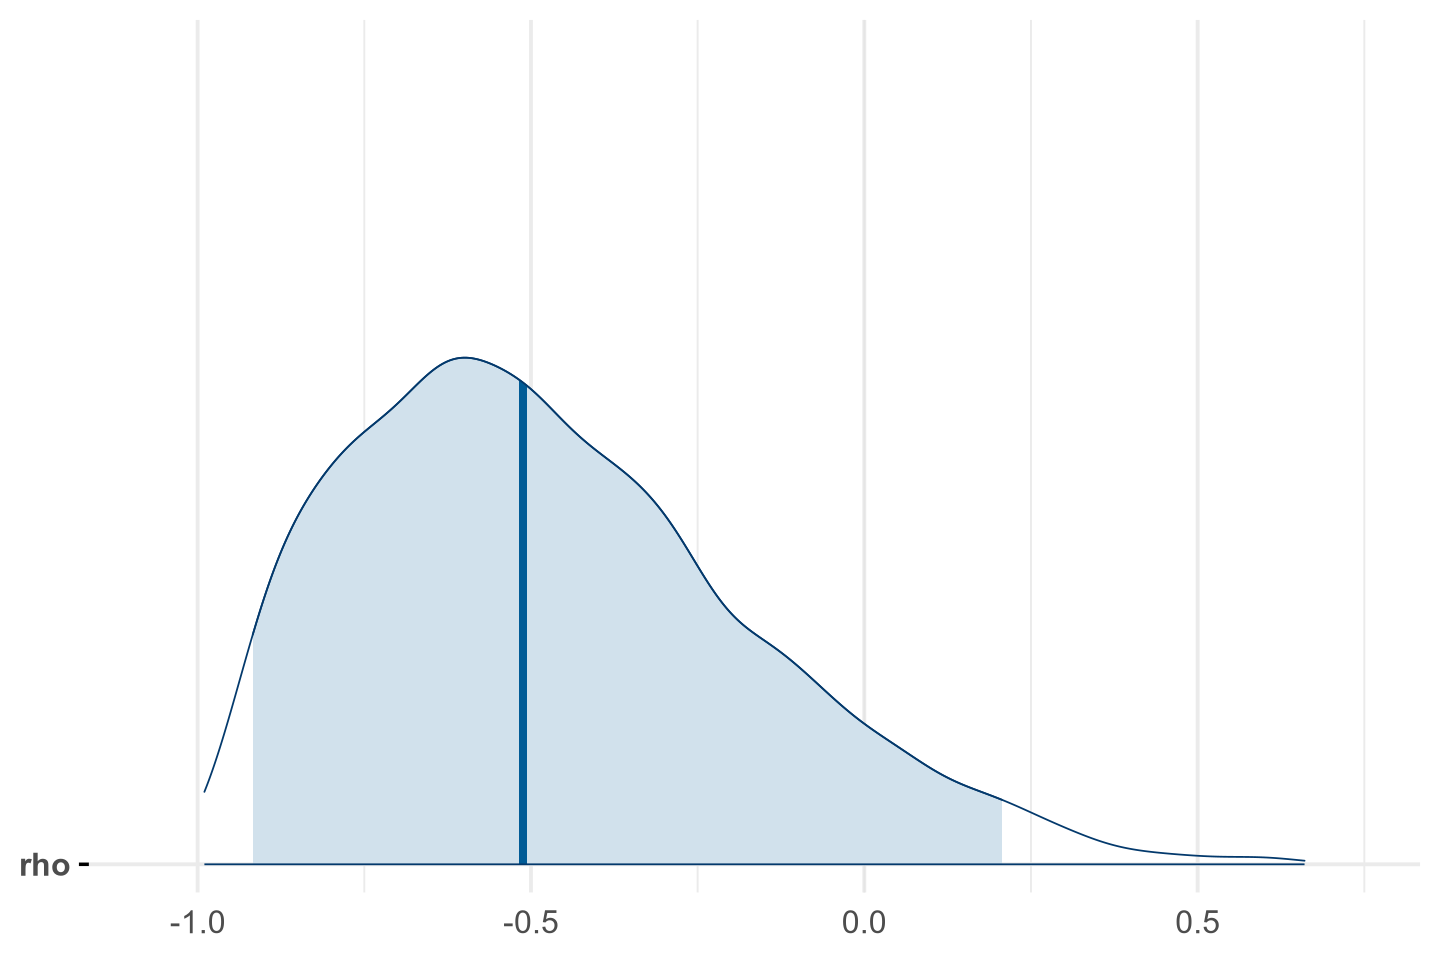

In [21]:
mcmc_areas(
    as.matrix(fit_vanilla_corr),
    pars = "rho",
    prob = 0.95
)

The posterior of $\rho$ includes 0, so no clear evidence for a correlation. 


We compute the log marginal likelihood for this model for later use.

In [22]:
capture.output({
    log_marginal_likelihood_vanilla_corr <- bridge_sampler(fit_vanilla_corr)
}, file = "/dev/null")
print(log_marginal_likelihood_vanilla_corr)

Bridge sampling estimate of the log marginal likelihood: 55.99841
Estimate obtained in 18 iteration(s) via method "normal".


A direct model comparison via Bayes Factor is not possible because the regression model models the distribution of `x` given `y`, while the correlation models the joint distribution. However, we can apply Pareto-smoothed leave one out cross-validation if we marginalize over `x` in the correlation model.

In [23]:
# extract log-likelihood matrix: draws x observations
log_lik1 <- extract_log_lik(fit_vanilla, parameter_name = "log_lik")
log_lik2 <- extract_log_lik(fit_vanilla_corr, parameter_name = "log_lik_y")

# compute LOO
loo1 <- loo(log_lik1)
loo2 <- loo(log_lik2)

# compare
loo_compare(loo1, loo2)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model1,0.000000,0.000000,-66.28474,3.308107,2.182711,0.1591767,132.5695,6.616215
model2,-0.401933,1.729217,-66.68667,2.315961,15.673588,0.6929146,133.3733,4.631923


So the regression model is slightly preferred, but the difference is almost indistinguishable from zero.


### The Ornstein-Uhlenbeck process


The OU process is a stochastic process, similar to Brownian motion. The crucial difference is that OU is ``random walk on a leash``. Technically, it is the mixture of a stochastic Brownian motion process and a deterministic trajectory exponentially converging to a mean value. It is characterized by the following distribution:
$$
X_t \sim \mathcal N\left(x_0e^{-\lambda t} + \mu (1-e^{-\lambda t}), \frac{\sigma}{\sqrt{2\lambda}}\sqrt{1-e^{-2\lambda t}}\right)
$$

The parameters are:

- $x_0$: the initial value of the process
- $\mu$: the mean value to which the process converges
- $\lambda$: the rate of convergence to the mean value
- $\sigma$: the volatility of the process
- $t$: the time at which the process is evaluated

The long-term equilibrium distribution is:
$$
X_t \sim \mathcal N(\mu, \frac{\sigma}{\sqrt{2\lambda}})
$$



## Logistic regression with a phylogenetic random effect

We now add a phylogenetic random effect to the logistic regression from above:


$$
\begin{align}
\alpha &\sim \mathcal N(0, 10)\\
\beta &\sim \mathcal N(0, 10)\\
\epsilon &\sim \mathcal N(0, \Sigma)\\
y &\sim \text{Bernoulli}(\text{logit}^{-1}(\alpha + \beta x + \epsilon))
\end{align}
$$

The covariance matrix $\Sigma$ of the phylogenetic random effect is given by

$$
\Sigma_{ij} = \frac{\sigma^2}{2\lambda} e^{-\lambda t_{ij}},
$$

where $t_{ij}$ is the patristic distance between language $i$ and language $j$ in the phylogeny.


A direct implementation of this formula in Stan is possible but inefficient. A better approach directly simulates the evolution of the latent variable $\epsilon$ along the phylgeny. This means that $\epsilon$ has a value not only at the tips but also at the internal nodes. The value at the root is sampled from the equilibrium distribution, and the value of the other nodes is drawn from the equation above, repeated here:

$$
X_t \sim \mathcal N(x_0e^{-\lambda t} + \mu (1-e^{-\lambda t}), \frac{\sigma^2}{2\lambda}(1-e^{-2\lambda t})).
$$

$X_t$ is now the value at the daughter node, $x_0$ at the mother node, and $t$ is the branch length.

In [24]:
stan_model_code_OU_regression = "
data {
  int<lower=1> N;                                         // number of tips with data
  int<lower=1> Nnodes;                                    // total number of nodes
  int<lower=1> Nedges;                                    // number of edges in the tree
  vector<lower=0, upper=1>[N] x;                          // predictor at tips
  array[N] int<lower=0, upper=1> y;                       // binary response at tips
  array[Nedges, 2] int<lower=1, upper=Nnodes> edges;      // parent → child
  vector<lower=0>[Nedges] edge_lengths;                   // edge lengths
  int<lower=1, upper=Nnodes> root_node;                   // index of root node
}

parameters {
  vector[Nnodes] z_std;       // standard normal reparam for latent z
  real<lower=0> sigma;        // OU diffusion
  real<lower=0> lambda;       // OU strength
  real mu;                    // OU mean
  real alpha;                 // intercept
  real beta;                  // slope
}

transformed parameters {
  vector[Nnodes] z;

  // root node
  z[root_node] = mu + (sigma / sqrt(2 * lambda)) * z_std[root_node];

  // recursive evolution
  for (e in 1:Nedges) {
    int edge_index = Nedges - e + 1; // reverse order for recursion
    int parent = edges[edge_index, 1];
    int child = edges[edge_index, 2];
    real len = edge_lengths[edge_index];

    real decay = exp(-lambda * len);
    real s = sigma * sqrt(-expm1(-2 * lambda * len) / (2 * lambda));
    real mn = mu + (z[parent] - mu) * decay;

    z[child] = mn + s * z_std[child];
  }
}

model {
  // Priors
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);
  sigma ~ lognormal(0, 1);
  lambda ~ lognormal(0, 1);
  mu ~ normal(0, 2);
  z_std ~ normal(0, 1);  // standard normal prior

  // Likelihood
  for (i in 1:N) {
    y[i] ~ bernoulli_logit(alpha + beta * x[i] + z[i]);
  }
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = bernoulli_logit_lpmf(y[i] | alpha + beta * x[i] + z[i]);
  }
}

"
stan_model_OU_regression <- stan_model(model_code = stan_model_code_OU_regression)

In [25]:
fit_OU_regression <- sampling(
    stan_model_OU_regression,
    data = stan_data,
    iter = 2000,
    chains = 4,
    control = list(adapt_delta = 0.95, max_treedepth = 15)
)

In [26]:
print(fit_OU_regression, pars = c("mu", "sigma", "lambda", "alpha", "beta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%   25%   50%   75% 97.5% n_eff Rhat
mu      0.11    0.03 1.97  -3.72 -1.22  0.11  1.42  3.97  4999    1
sigma   7.57    0.15 6.11   1.53  3.62  5.72  9.53 24.19  1648    1
lambda  0.11    0.00 0.04   0.04  0.08  0.10  0.13  0.21  1820    1
alpha   3.35    0.12 4.60  -5.25  0.58  3.10  5.92 13.76  1529    1
beta   -2.28    0.11 4.32 -11.53 -4.63 -2.13 -0.03  6.66  1658    1

Samples were drawn using NUTS(diag_e) at Sun Jun 15 09:24:57 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


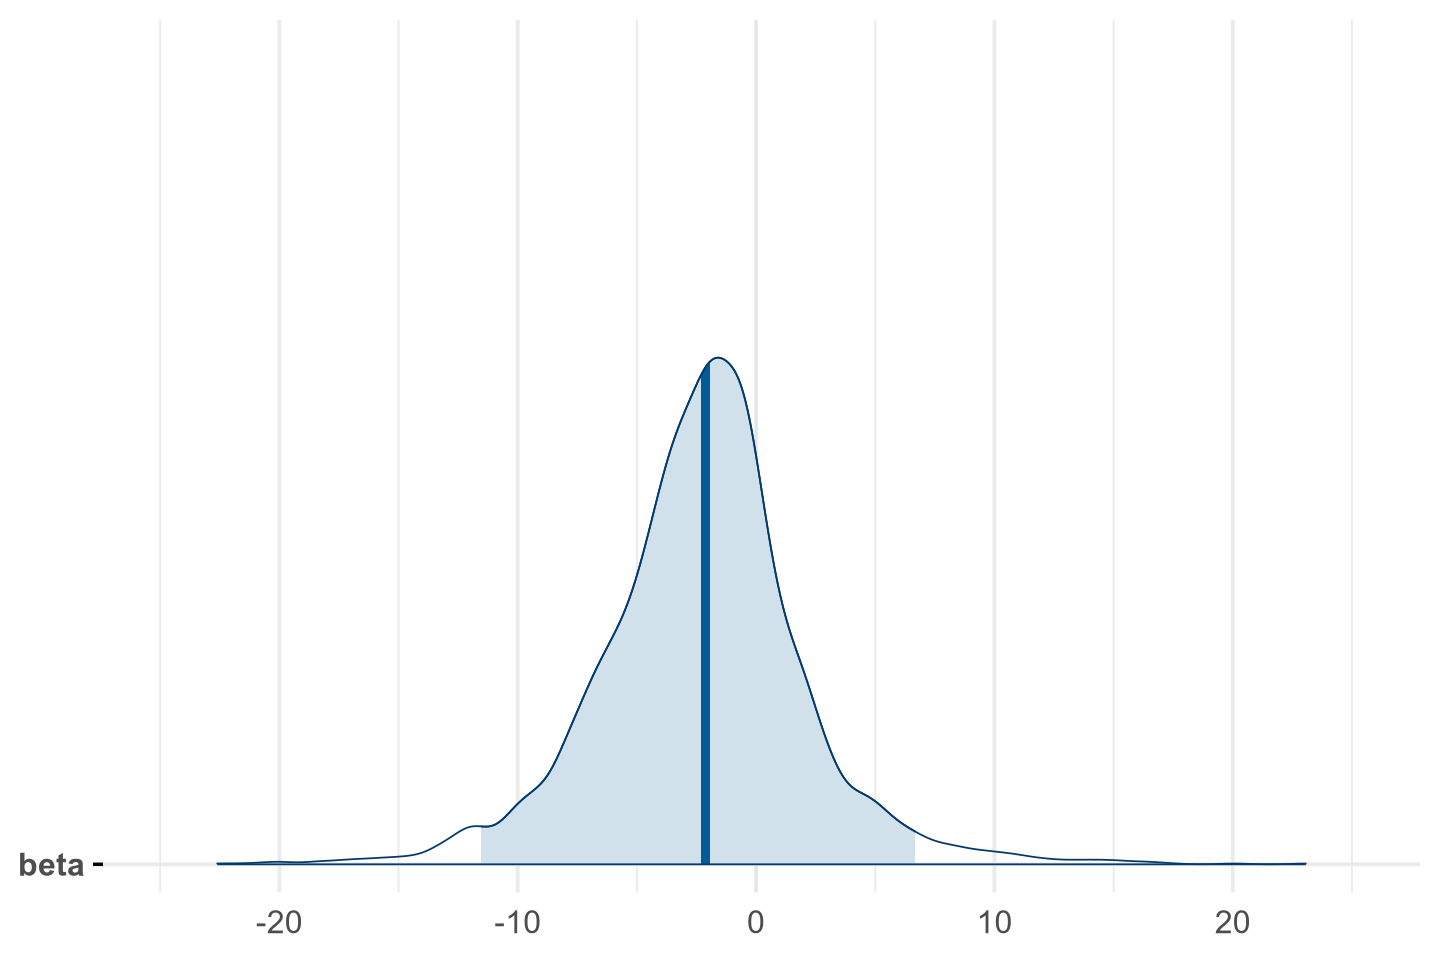

In [27]:
mcmc_areas(
    as.matrix(fit_OU_regression),
    pars = "beta",
    prob = 0.95
)

In [28]:
capture.output({
    log_marginal_likelihood_OU_regression <- bridge_sampler(fit_OU_regression)
}, file = "/dev/null")
print(log_marginal_likelihood_OU_regression)

Bridge sampling estimate of the log marginal likelihood: 133.9215
Estimate obtained in 11 iteration(s) via method "normal".


Now we can compute the Bayes factor between the vanilla regression and the OU phylogenetic regression.

In [29]:
log_marginal_likelihood_OU_regression$logml - log_marginal_likelihood_vanilla_regression$logml

[1] 198.5346

This is extremely strong evidence in favor of the OU model.

The HPD for $\beta$ is very broad and includes 0. So there is no evidence for the significant effect of the order of adnominal property words on verb position.

However, I find it hard to wrap my mind around what such a model actually means. It says that there is a latent variable $\epsilon$ evolving along the tree, and the probability of a language being verb final depends both on this latent variable and on the order of adjective-noun.

A more realistic model, it seems to me, is one where there are

- a latent variable determining adjective-noun order, and
- a latent variable determining verb position.

These latent variables evolve simultaneously along the tree. If there is a dependency between the two observed variables resulting from diachronic processes, there is a correlation between the diachronic changes of the variables.

This can be implemented in an extension of the bivariate correlation model used above.

The model specification is as follows, where $N$ is the number of languages, and $t_{l_1, l_2}$ is the length of from the root of the tree to the most recent common ancestor of $l_1$ and $l_2$:

$$	
\begin{align}
R &\sim \text{LKJ}(2)\\
\Sigma_{(l_1, k_1), (l_2, k_2)} &= R_{k_1, k_2}\cdot \frac{\sigma_{k_1}\sigma_{k_2}}{\lambda_{k_1}+\lambda_{k_2}}\left(1-e^{-(\lambda_{k_1}+\lambda_{k_2})t_{l_1, l_2}}\right)
\\
\mu_i &= \mathcal N(\mathbf 0, 2)\\
\sigma_i &= \text{Lognormal}(0,1)\\
\lambda_i &= \text{Lognormal}(0,1)\\
z &\sim \mathcal N(\text{repeat}(\mu, N), \Sigma)\\
x_i &\sim \text{Bernoulli}(\text{logit}^{-1}(z_{i,1}))\\
y_i &\sim \text{Bernoulli}(\text{logit}^{-1}(z_{i,2}))
\end{align}
$$

In [30]:
stan_code_OU_correlation <- "
data {
  int<lower=1> N;                                        // number of tips with data
  int<lower=1> Nnodes;                                   // total number of nodes
  int<lower=1> Nedges;                                   // number of edges in the tree
  array[N] int<lower=0, upper=1> x;                      // first binary response
  array[N] int<lower=0, upper=1> y;                      // second binary response
  array[Nedges, 2] int<lower=1, upper=Nnodes> edges;     // parent → child
  vector<lower=0>[Nedges] edge_lengths;                  // edge lengths
  int<lower=1, upper=Nnodes> root_node;                  // index of root node
}

parameters {
  matrix[Nnodes, 2] z_std;                   // standard-normal latent variables
  vector<lower=0>[2] sigma;                  // OU diffusion parameters
  vector<lower=0>[2] lambda;                 // OU pull strengths
  vector[2] mu;                              // OU stationary means
  cholesky_factor_corr[2] L_std;             // Cholesky factor of correlation matrix
}

transformed parameters {
  matrix[Nnodes, 2] z;     // latent values
  real rho = L_std[2, 1];  // correlation coefficient

  // Root node, drawn from OU stationary distribution
  z[root_node] = (mu + (sigma ./ sqrt(2 * lambda)) .* (L_std * to_vector(z_std[root_node])))';



  // Recursive evolution
  for (e in 1:Nedges) {
    int edge_index = Nedges - e + 1;   // reverse order for recursion, root to tips
    int parent = edges[edge_index, 1];
    int child  = edges[edge_index, 2];
    real len = edge_lengths[edge_index];

    // Vectorized decay and scale
    vector[2] decay = exp(-lambda * len);
    vector[2] s = sigma .* sqrt(-expm1(-2 * lambda * len) ./ (2 * lambda));
    vector[2] mean = mu + (to_vector(z[parent]) - mu) .* decay;
    vector[2] eps  = L_std * z_std[child]';
    z[child] = (mean + s .* eps)';
  }
}

model {
  // Priors
  sigma ~ lognormal(0, 1);
  lambda ~ lognormal(0, 1);
  mu ~ normal(0, 2);
  L_std ~ lkj_corr_cholesky(2.0);
  to_vector(z_std) ~ normal(0, 1);

  // Likelihood
  for (i in 1:N) {
    x[i] ~ bernoulli_logit(z[i, 1]);
    y[i] ~ bernoulli_logit(z[i, 2]);
  }
}


generated quantities {
    vector[N] log_lik_x;
    vector[N] log_lik_y;

    for (i in 1:N) {
        log_lik_x[i] = bernoulli_logit_lpmf(x[i] | z[i, 1]);
        log_lik_y[i] = bernoulli_logit_lpmf(y[i] | z[i, 2]);
    }
}

"
stan_model_OU_correlation <- stan_model(model_code = stan_code_OU_correlation)

In [31]:
fit_OU_correlation <- sampling(
    stan_model_OU_correlation,
    data = stan_data,
    iter = 10000,
    thin = 10,
    chains = 4,
    control = list(adapt_delta = 0.95, max_treedepth = 15)
)

In [32]:
print(fit_OU_correlation, pars=c("mu", "sigma", "lambda", "rho"))

Inference for Stan model: anon_model.
4 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu[1]      1.81    0.02 1.09  0.00  1.07  1.67  2.43  4.24  2014    1
mu[2]      0.70    0.03 1.25 -1.79 -0.08  0.63  1.42  3.37  2011    1
sigma[1]   3.22    0.05 2.37  0.78  1.77  2.63  3.89  9.12  1944    1
sigma[2]   4.29    0.08 3.54  0.94  2.07  3.27  5.28 13.33  1954    1
lambda[1]  0.21    0.01 0.23  0.04  0.11  0.16  0.24  0.60  1724    1
lambda[2]  0.11    0.00 0.04  0.04  0.08  0.10  0.13  0.20  1893    1
rho       -0.27    0.00 0.20 -0.65 -0.41 -0.28 -0.14  0.13  1731    1

Samples were drawn using NUTS(diag_e) at Sun Jun 15 09:29:50 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


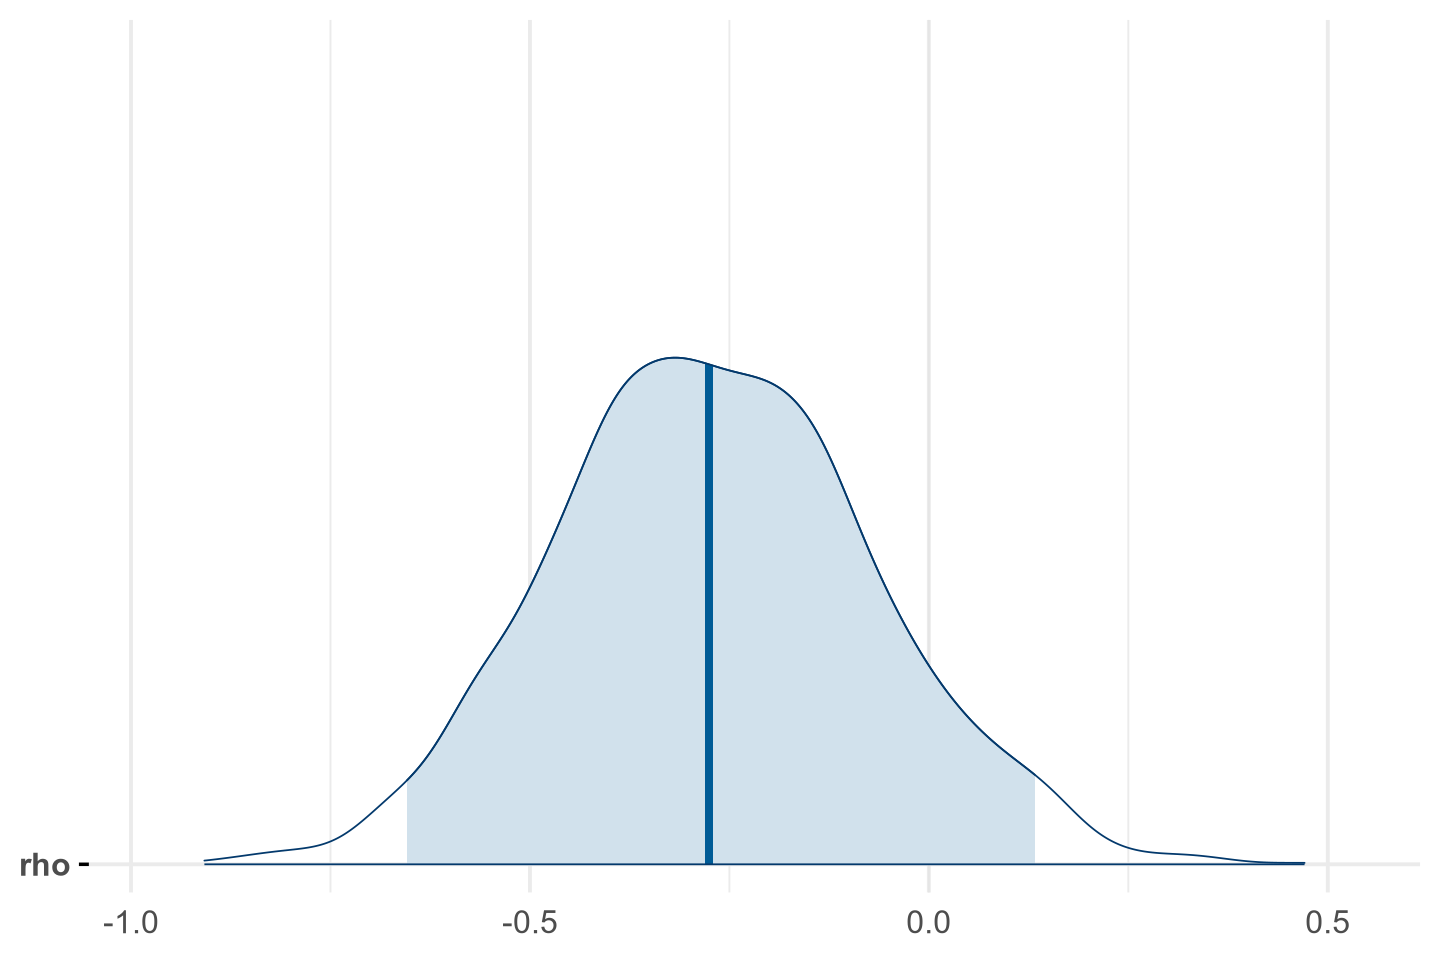

In [33]:
mcmc_areas(
    as.matrix(fit_OU_correlation),
    pars = "rho",
    prob = 0.95
)

Since the HPD of $\rho$ includes 0, we conclude that there is no credible evidence for a diachronic correlation between the two variables.

Bayes factor:

In [34]:
capture.output({
    log_marginal_likelihood_OU_correlation <- bridge_sampler(
        fit_OU_correlation, silent = TRUE, maxiter = 10000
    )
}, file = "/dev/null")
print(log_marginal_likelihood_OU_correlation)

Warning message:
“logml could not be estimated within maxiter, rerunning with adjusted starting value. 
Estimate might be more variable than usual.”


Bridge sampling estimate of the log marginal likelihood: 262.165
Estimate obtained in 10001 iteration(s) via method "normal".


In [35]:
log_marginal_likelihood_OU_correlation$logml - log_marginal_likelihood_vanilla_corr$logml

[1] 206.1666

Again we find overwhelming evidence in favor of the phylogenetic model.

We can complement model comparison via Bayes Factor with Pareto-smoothed leave-one-out cross-validation.

In [36]:
# extract log-likelihood matrix: draws x observations

log_lik3 <- extract_log_lik(fit_OU_regression, parameter_name = "log_lik")
log_lik4 <- extract_log_lik(fit_OU_correlation, parameter_name = "log_lik_y")


# compute LOO

loo3 <- loo(log_lik3)
loo4 <- loo(log_lik4)

# compare
loo_compare(loo1, loo2, loo3, loo4)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model3,0.000000,0.000000,-25.71197,2.957007,19.862203,2.5089037,51.42393,5.914014
model4,-6.405744,1.222448,-32.11771,3.760348,22.404352,3.0056950,64.23542,7.520696
model1,-40.572773,3.467631,-66.28474,3.308107,2.182711,0.1591767,132.56948,6.616215
model2,-40.974706,3.081030,-66.68667,2.315961,15.673588,0.6929146,133.37335,4.631923


The two phylogenetic models perform massively better than the vanilla models. Furthermore if our goal is to predict the verb position of an unseen language from its noun-adjective order and its position in the tree, the regression model is superior to the correlation model.

As a nice side effect of the explicit modeling of the diachronic histories, we can plot the posterior means of the latent variables at the internal nodes, thereby visualizing the evolution of the latent variables. 

In [37]:
posterior_df <- as_draws_df(fit_OU_correlation)
z_posterior <- posterior_df %>%
  spread_draws(z[i, j]) %>%
  group_by(i, j) %>%
  summarise(mean_z = mean(z), .groups = "drop")
z_adjective <- z_posterior %>%
    filter(j == 1) %>%
    pull(mean_z)
z_vo <- z_posterior %>%
    filter(j == 2) %>%
    pull(mean_z)
pruned_tree$node.label <- as.character(
    (length(pruned_tree$tip.label) + 1):(length(pruned_tree$tip.label) + pruned_tree$Nnode)
)


tree_plot <- ggtree(pruned_tree)
tree_info <- tree_plot$data
tree_info$node.label <- as.character(tree_info$label)

In [38]:
for (i in 1:nrow(tree_info)) {
    if (tree_info$isTip[i]) {
        # If it's a tip, get the corresponding Glottocode
        glottocode <- tree_info$label[i]
        # Find the index of the Glottocode in d_ie
        index <- which(pruned_tree$tip.label == glottocode)
        # Assign the Affix value to the node label
        tree_info$node.label[i] <- index
    } else {
        # If it's not a tip, copy label
        tree_info$node.label[i] <- as.integer(tree_info$node.label[i])
    }
}


node_data <- tibble(
  node.label = as.character(1:length(z_adjective)),
  z_adjective = z_adjective,
  z_vo = z_vo
)


tree_data <- tree_info %>%
  left_join(node_data, by = "node.label")

tree_data <- tree_data %>%
    left_join(
        rename(select(d, Language_ID, GB193, GB133),
        label=Language_ID)
    ) 
tree_data <- tree_data %>%
  mutate(GB193 = factor(GB193)) %>%
  mutate(GB133 = factor(GB133))

Joining with `by = join_by(label)`


In [39]:

custom_palette <- paletteer_c("scico::roma", 30)

In [40]:
# Plot with two color scales
p1 <- ggtree(pruned_tree, layout="circular", branch.length = "none") %<+% tree_data +
  # First color scale for branches
  geom_tree(aes(color = plogis(z_adjective)), size = 1) +
  scale_color_gradientn(colors = custom_palette, name = "p(NAdj)") +

  # Reset color scale
  ggnewscale::new_scale_color() +

  # Color tip points by a discrete or continuous variable
  geom_tippoint(aes(color = GB193), size = 3) +
  scale_color_manual(values = c("1" = custom_palette[1], "2" = custom_palette[30])) +
  guides(color = guide_legend(override.aes = list(size = 4))) +
  theme(legend.position = "left") +
  theme(text = element_text(size = 18), legend.text = element_text(size = 18))


In [41]:
p2 <- ggtree(pruned_tree, layout = "circular", branch.length="none") %<+% tree_data +
  # First color scale for branches
  geom_tree(aes(color = plogis(z_vo)), size=1) +
  scale_color_gradientn(colors = custom_palette, name = "p(VO)") +

  # Reset color scale
  ggnewscale::new_scale_color() +

  # Color tip points by a discrete or continuous variable
  geom_tippoint(aes(color = GB133), size = 3) +
  scale_color_manual(values = c("0" = custom_palette[1], "1" = custom_palette[30])) +
  guides(color = guide_legend(override.aes = list(size = 4))) +
  theme(text = element_text(size = 18), legend.text = element_text(size = 18))

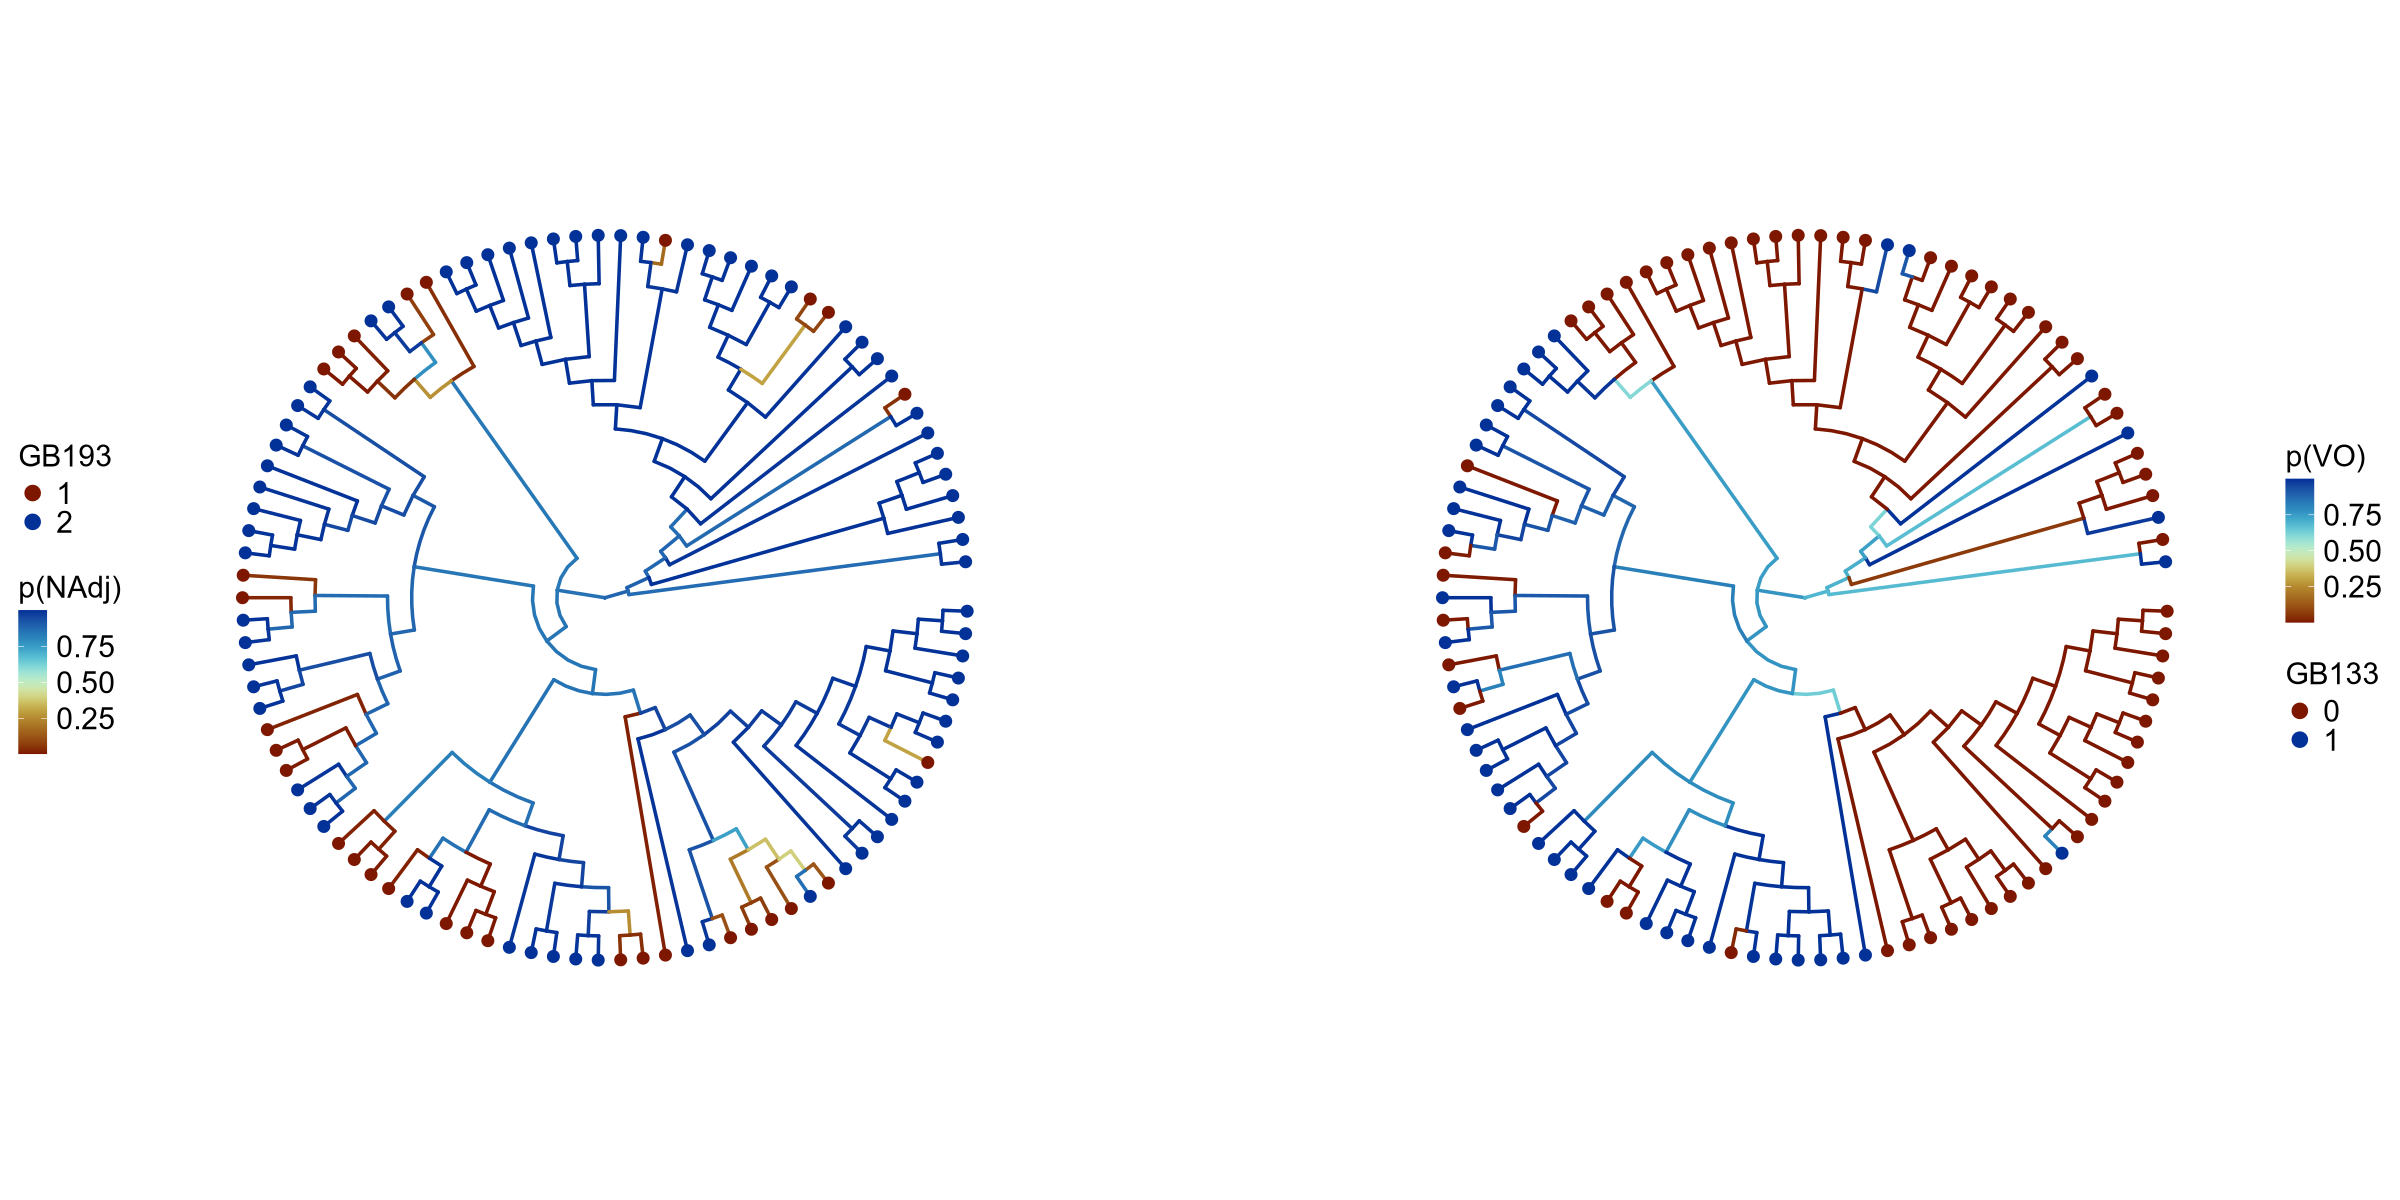

In [42]:
options(repr.plot.width = 20, repr.plot.height = 10) 
plot_grid(p1, p2, ncol = 2, align = "hv", rel_widths = c(1, 1))


In [43]:
options(repr.plot.width = 12, repr.plot.height = 8)  # For base R plots in Jupyter

Another advantage of this approach (both the regression and the correlation variant) is that it can easily be combined with family-level or macroarea-level random effects. Also, geographic random effects can easily be added.

More details can be found in my arxiv paper *Computational Tyology* (https://arxiv.org/abs/2504.15642)

## Pagel & Meade style test for correlation

The test for correlation using CTMC, as developed by Pagel & Meade (2006) and implemented in BayesTraits, can also be implemented in Stan, using Felsenstein's pruning algorithm.


In [44]:
stan_modelcode_ctmc_independent = "
data {
  int<lower=1> N;                                     // number of tips with data
  int<lower=1> Nnodes;                                // total number of nodes
  int<lower=1> Nedges;                                // number of edges in the tree
  array[N] int<lower=0, upper=1> x;                   // first variable
  array[N] int<lower=0, upper=1> y;                   // second variable
  array[Nedges, 2] int<lower=1, upper=Nnodes> edges;  // parent → child
  vector<lower=0>[Nedges] edge_lengths;               // edge lengths
  int<lower=1, upper=Nnodes> root_node;               // index of root node
}

parameters {
// parameters of the CTMCs
  vector<lower=0>[2] rates;
  simplex[2] pi_1;
  simplex[2] pi_2;
}

transformed parameters {
  // Q matrices
  matrix[2, 2] Q1;
  matrix[2, 2] Q2;

  Q1[1,1] = -rates[1] * pi_1[2];
  Q1[1,2] =  rates[1] * pi_1[2];
  Q1[2,1] =  rates[1] * pi_1[1];
  Q1[2,2] = -rates[1] * pi_1[1];

  Q2[1,1] = -rates[2] * pi_2[2];
  Q2[1,2] =  rates[2] * pi_2[2];
  Q2[2,1] =  rates[2] * pi_2[1];
  Q2[2,2] = -rates[2] * pi_2[1];

  // matrices for Felsenstein recursion
  matrix[Nnodes, 2] loglikelihood_x;
  matrix[Nnodes, 2] loglikelihood_y;

  // initialize loglikelihood matrices with log(0)
  for (n in 1:Nnodes) {
    loglikelihood_x[n] = rep_row_vector(negative_infinity(), 2);
    loglikelihood_y[n] = rep_row_vector(negative_infinity(), 2);
  }

  // set the loglikelihoods for the tips
  for (i in 1:N) {
    loglikelihood_x[i, x[i] + 1] = 0;
    loglikelihood_y[i, y[i] + 1] = 0;
  }

  // recursive computation of loglikelihoods
  for (e in 1:Nedges) {
    int parent = edges[e, 1];
    int child = edges[e, 2];
    real t = edge_lengths[e];

    matrix[2,2] P1 = matrix_exp(Q1 * t);
    matrix[2,2] P2 = matrix_exp(Q2 * t);

    for (k in 1:2) {
      loglikelihood_x[parent, k] = log_sum_exp(to_vector(log(P1[k]) + loglikelihood_x[child]));
      loglikelihood_y[parent, k] = log_sum_exp(to_vector(log(P2[k]) + loglikelihood_y[child]));
    }
  }
}

model {
  rates ~ lognormal(-1, 0.5);
  pi_1 ~ dirichlet(rep_vector(2, 2));
  pi_2 ~ dirichlet(rep_vector(2, 2));

  target += log_sum_exp(loglikelihood_x[root_node] + log(pi_1)');
  target += log_sum_exp(loglikelihood_y[root_node] + log(pi_2)');
}

generated quantities { // compute log p(x_i|x_{-i}, y, theta) and log p(y_i| x, y_{-i}, theta) for each i
  vector[N] x_log_lik;
  vector[N] y_log_lik;

  {
    matrix[Nnodes, 2] ll_x;
    matrix[Nnodes, 2] ll_y;

    for (i in 1:N) {
      // initialize with log(0)
      for (n in 1:Nnodes) {
        ll_x[n] = rep_row_vector(negative_infinity(), 2);
        ll_y[n] = rep_row_vector(negative_infinity(), 2);
      }

      // flip x[i] and y[i]
      for (j in 1:N) {
        int xj = (j == i) ? 1 - x[j] : x[j];
        int yj = (j == i) ? 1 - y[j] : y[j];
        ll_x[j, xj + 1] = 0;
        ll_y[j, yj + 1] = 0;
      }

      // recurse up the tree
      for (e in 1:Nedges) {
        int parent = edges[e, 1];
        int child = edges[e, 2];
        real t = edge_lengths[e];
        matrix[2,2] P1 = matrix_exp(Q1 * t);
        matrix[2,2] P2 = matrix_exp(Q2 * t);

        for (k in 1:2) {
          ll_x[parent, k] = log_sum_exp(to_vector(log(P1[k]) + ll_x[child]));
          ll_y[parent, k] = log_sum_exp(to_vector(log(P2[k]) + ll_y[child]));
        }
      }

      real full_loglik_x = log_sum_exp(loglikelihood_x[root_node] + log(pi_1)');
      real flip_loglik_x = log_sum_exp(ll_x[root_node] + log(pi_1)');
      x_log_lik[i] = full_loglik_x - log_sum_exp(full_loglik_x, flip_loglik_x);

      real full_loglik_y = log_sum_exp(loglikelihood_y[root_node] + log(pi_2)');
      real flip_loglik_y = log_sum_exp(ll_y[root_node] + log(pi_2)');
      y_log_lik[i] = full_loglik_y - log_sum_exp(full_loglik_y, flip_loglik_y);
    }
  }
}

"
stan_model_ctmc_independent <- stan_model(model_code=stan_modelcode_ctmc_independent)


In [45]:
fit_ctmc_independent <- sampling(
    stan_model_ctmc_independent,
    data = stan_data,
    iter = 2000,
    chains = 4
)

In [46]:
print(fit_ctmc_independent, pars=c("pi_1", "pi_2", "rates"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
pi_1[1]  0.40       0 0.20 0.07 0.25 0.39 0.54  0.80  4525    1
pi_1[2]  0.60       0 0.20 0.20 0.46 0.61 0.75  0.93  4525    1
pi_2[1]  0.60       0 0.20 0.19 0.45 0.61 0.75  0.93  4926    1
pi_2[2]  0.40       0 0.20 0.07 0.25 0.39 0.55  0.81  4926    1
rates[1] 0.42       0 0.22 0.14 0.26 0.37 0.52  1.01  3030    1
rates[2] 0.42       0 0.23 0.14 0.26 0.37 0.52  0.99  3461    1

Samples were drawn using NUTS(diag_e) at Sun Jun 15 09:33:16 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [47]:
capture.output({
    log_marginal_likelihood_ctmc_independent <- bridge_sampler(fit_ctmc_independent)
}, file = "/dev/null")
print(log_marginal_likelihood_ctmc_independent)

Bridge sampling estimate of the log marginal likelihood: -6.35481
Estimate obtained in 5 iteration(s) via method "normal".


In [48]:
stan_modelcode_ctmc_dependent = "
functions {
  vector stationary_distribution(matrix Q) {
    int K = rows(Q);
    matrix[K, K] A = Q';
    vector[K] b = rep_vector(0.0, K);
    
    // Replace one row by sum-to-one constraint
    A[K] = rep_row_vector(1.0, K);
    b[K] = 1.0;

    return mdivide_left(A, b);  // solve A * pi = b
  }
}


data {
  int<lower=1> N;
  int<lower=1> Nnodes;
  int<lower=1> Nedges;
  array[N] int<lower=0, upper=1> x;
  array[N] int<lower=0, upper=1> y;
  array[Nedges, 2] int<lower=1, upper=Nnodes> edges;
  vector<lower=0>[Nedges] edge_lengths;
  int<lower=1, upper=Nnodes> root_node;
}

transformed data {
   array[N] int z;
   for (i in 1:N) {
      z[i] = 2* x[i] + y[i];
   }
}

parameters {
  real<lower=0> total_rate;
  simplex[8] rates;
}

transformed parameters {
  // Q matrices
  matrix[4, 4] Q;
  Q[1,1] = -rates[1] - rates[2];
  Q[1,2] = rates[1];
  Q[1,3] = rates[2];
  Q[1,4] = 0;
  Q[2,1] = rates[3];
  Q[2,2] = -rates[3] - rates[4];
  Q[2,3] = 0;
  Q[2,4] = rates[4];
  Q[3,1] = rates[5];
  Q[3,2] = 0;
  Q[3,3] = -rates[5] - rates[6];
  Q[3,4] = rates[6];
  Q[4,1] = 0;
  Q[4,2] = rates[7];
  Q[4,3] = rates[8];
  Q[4,4] = -rates[7] - rates[8];
  Q = total_rate * Q;

  vector[4] pi = stationary_distribution(Q);

  matrix[Nnodes, 4] loglikelihood;

  for (n in 1:Nnodes) {
    loglikelihood[n] = rep_row_vector(negative_infinity(), 4);
  }

  for (i in 1:N) {
    loglikelihood[i, z[i] + 1] = 0;
  }

  for (e in 1:Nedges) {
    int parent = edges[e, 1];
    int child = edges[e, 2];
    real t = edge_lengths[e];

    matrix[4,4] P = matrix_exp(Q * t);

    for (k in 1:4) {
      loglikelihood[parent, k] = log_sum_exp(to_vector(log(P[k]) + loglikelihood[child]));
    }
  }
}

model {
  total_rate ~ gamma(1, 1);
  rates ~ dirichlet(rep_vector(1, 8));

  target += log_sum_exp(loglikelihood[root_node] + log(pi)');
}

generated quantities {
  vector[N] x_log_lik;
  vector[N] y_log_lik;

  {
    matrix[Nnodes, 4] ll;
    real loglik;
    real loglik_flipped;

    for (i in 1:N) {
      // --- FULL loglikelihood ---
      for (n in 1:Nnodes)
        ll[n] = rep_row_vector(negative_infinity(), 4);

      for (j in 1:N)
        ll[j, z[j] + 1] = 0;

      for (e in 1:Nedges) {
        int parent = edges[e, 1];
        int child  = edges[e, 2];
        real t = edge_lengths[e];
        matrix[4,4] P = matrix_exp(Q * t);
        for (k in 1:4)
          ll[parent, k] = log_sum_exp(to_vector(log(P[k]) + ll[child]));
      }

      loglik = log_sum_exp(ll[root_node] + log(pi)');

      // --- x_i flipped ---
      for (n in 1:Nnodes)
        ll[n] = rep_row_vector(negative_infinity(), 4);

      for (j in 1:N) {
        int zj = z[j];
        if (j == i) {
          // flip x but keep y
          if (zj == 0) zj = 2;
          else if (zj == 1) zj = 3;
          else if (zj == 2) zj = 0;
          else if (zj == 3) zj = 1;
        }
        ll[j, zj + 1] = 0;
      }

      for (e in 1:Nedges) {
        int parent = edges[e, 1];
        int child  = edges[e, 2];
        real t = edge_lengths[e];
        matrix[4,4] P = matrix_exp(Q * t);
        for (k in 1:4)
          ll[parent, k] = log_sum_exp(to_vector(log(P[k]) + ll[child]));
      }

      loglik_flipped = log_sum_exp(ll[root_node] + log(pi)');
      x_log_lik[i] = loglik - log_sum_exp([loglik, loglik_flipped]');
    }

    // Now repeat the same for y
    for (i in 1:N) {
      for (n in 1:Nnodes)
        ll[n] = rep_row_vector(negative_infinity(), 4);

      for (j in 1:N)
        ll[j, z[j] + 1] = 0;

      for (e in 1:Nedges) {
        int parent = edges[e, 1];
        int child  = edges[e, 2];
        real t = edge_lengths[e];
        matrix[4,4] P = matrix_exp(Q * t);
        for (k in 1:4)
          ll[parent, k] = log_sum_exp(to_vector(log(P[k]) + ll[child]));
      }

      loglik = log_sum_exp(ll[root_node] + log(pi)');

      for (n in 1:Nnodes)
        ll[n] = rep_row_vector(negative_infinity(), 4);

      for (j in 1:N) {
        int zj = z[j];
        if (j == i) {
          // flip y but keep x
          if (zj == 0) zj = 1;
          else if (zj == 1) zj = 0;
          else if (zj == 2) zj = 3;
          else if (zj == 3) zj = 2;
        }
        ll[j, zj + 1] = 0;
      }

      for (e in 1:Nedges) {
        int parent = edges[e, 1];
        int child  = edges[e, 2];
        real t = edge_lengths[e];
        matrix[4,4] P = matrix_exp(Q * t);
        for (k in 1:4)
          ll[parent, k] = log_sum_exp(to_vector(log(P[k]) + ll[child]));
      }

      loglik_flipped = log_sum_exp(ll[root_node] + log(pi)');
      y_log_lik[i] = loglik - log_sum_exp([loglik, loglik_flipped]');
    }
  }
}

"

stan_model_ctmc_dependent <- stan_model(model_code=stan_modelcode_ctmc_dependent)

In [49]:
fit_ctmc_dependent <- sampling(
    stan_model_ctmc_dependent,
    data = stan_data,
    iter = 2000,
    chains = 4
)

In [50]:
print(fit_ctmc_dependent, pars=c("total_rate", "rates", "pi"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
total_rate 0.99    0.01 0.95 0.03 0.29 0.70 1.41  3.51  6253    1
rates[1]   0.12    0.00 0.10 0.00 0.04 0.09 0.17  0.39  5673    1
rates[2]   0.16    0.00 0.12 0.01 0.07 0.13 0.23  0.45  6022    1
rates[3]   0.14    0.00 0.12 0.00 0.05 0.11 0.19  0.43  6009    1
rates[4]   0.14    0.00 0.11 0.01 0.05 0.11 0.19  0.43  5493    1
rates[5]   0.09    0.00 0.09 0.00 0.02 0.06 0.12  0.32  6328    1
rates[6]   0.09    0.00 0.08 0.00 0.03 0.06 0.12  0.31  4849    1
rates[7]   0.12    0.00 0.10 0.00 0.04 0.09 0.17  0.38  5197    1
rates[8]   0.16    0.00 0.12 0.01 0.07 0.14 0.23  0.45  5582    1
pi[1]      0.21    0.00 0.16 0.02 0.09 0.17 0.30  0.62  4658    1
pi[2]      0.18    0.00 0.15 0.01 0.07 0.14 0.24  0.56  5196    1
pi[3]      0.40    0.00 0.21 0.08 0.23 0.38 0.55  0.

In [51]:
capture.output({
    log_marginal_likelihood_ctmc_dependent <- bridge_sampler(fit_ctmc_dependent)
}, file = "/dev/null")
print(log_marginal_likelihood_ctmc_dependent)

Bridge sampling estimate of the log marginal likelihood: -9.89675
Estimate obtained in 5 iteration(s) via method "normal".


And now the Bayes Factor:

In [52]:
(log_marginal_likelihood_ctmc_independent$logml - log_marginal_likelihood_ctmc_dependent$logml)

[1] 3.541939

So we find moderate evidence in favor of the independent model.

In this connection it is worth pointing out that the OU/logistic model provides a massively better fit than the CTMC model.

In [53]:
(log_marginal_likelihood_OU_correlation$logml - log_marginal_likelihood_ctmc_independent$logml)

[1] 268.5198

This is reinforced by model comparison via Pareto-smoothed leave-one-out cross-validation.

In [54]:
# extract log-likelihood matrix: draws x observations
log_lik5 <- extract_log_lik(fit_ctmc_independent, parameter_name = "y_log_lik")
log_lik6 <- extract_log_lik(fit_ctmc_dependent, parameter_name = "y_log_lik")


# compute LOO
loo5 <- loo(log_lik5)
loo6 <- loo(log_lik6)

# compare
loo_compare(loo1, loo2, loo3, loo4, loo5, loo6)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”


R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model3,0.000000,0.000000,-25.71197,2.95700698,19.8622028,2.5089037,51.42393,5.91401395
model4,-6.405744,1.222448,-32.11771,3.76034804,22.4043521,3.0056950,64.23542,7.52069608
model1,-40.572773,3.467631,-66.28474,3.30810745,2.1827108,0.1591767,132.56948,6.61621491
model2,-40.974706,3.081030,-66.68667,2.31596135,15.6735881,0.6929146,133.37335,4.63192271
model6,-43.576747,2.958189,-69.28871,0.02600414,0.2303480,0.2303480,138.57743,0.05200827
model5,-43.612381,2.956627,-69.32435,0.00962990,0.1864048,0.1864048,138.64870,0.01925980


All the models discussed here use a single phylogeny. It is possible to use a sample of phylogenies to factor in phylogenetic uncertainty in this framework, but it makes the models more complex and the fitting computationally more demanding.

Essentially, what you have to do is:

- Construct a 3-dimensional `edge` array (number of edges $\times$ 2 $\times$ number of trees), where each layer `edge[i,j,k]` indicates that there is a branch from node `i` to node `j` in tree number `k`. You have to make sure that all trees are in postorder.

- Construct a number of edges $\times$ number of trees matrix `edge_lengths`

- In the Stan model, you have to loop over all edges in all trees. So the phylogenetic recursion should look like

```{stan}
for (tr in 1:Ntrees) {
    for (e in 1:Nedges) {
        int parent = edges[e, 1, tr];
        int child = edges[e, 2, tr];
        real t = edge_lengths[e, tr];
        ...
    }
}
```

- Inside the model block, add the line

```{stan}
target -= log(Ntrees);
```

Together, this averages over the likelihoods of all trees in the tree sample. Since the likelihoods of all trees in the sample have to be computed, this will slow down model fitting quite a bit.